<h1 style="text-align:center;vertical-align:middle">Oakland Crime频繁模式与关联规则挖掘</h1>
  
<div style="text-align:center;vertical-align:middle;margin-top:20px"><a  href = "https://github.com/PluckySaltyfish/DataMiningClass/Assignment7">仓库地址点这里</a></div>

## 目录
- [1 原始数据概要](#1)
- [2 项(Item)选择与数据集转换](#2)
- [3 频繁模式计算](#3)
- [4 关联规则导出与评价](#4)
- [5 挖掘结果分析与可视化](#5)
    - [挖掘结果分析](#5.1)
    - [关联规则可视化](#5.2)
- [附录 其它年份的挖掘结果](#6)
    - [2012](#2012)
    - [2013](#2013)
    - [2014](#2014)
    - [2015](#2015)
    - [2016](#2016)

<h2 id="1">1 原始数据概要</h2>
数据集给出了2011-2016年OakLand的犯罪情况记录。
每行数据包括10个列，分别代表：

- `Agency` 机构名称，所有文件除了缺失值，该属性只有唯一值`OP`,资料及讨论区并没有给出具体含义,应该是指警方来源。
- `Create Time` 案件创建时间
- `Location` 案件发生地点
- `Area ID` 案件发生区域代码
- `Beat` 案件发生的巡逻区（Beat为警用术语，用于划分每个警官的巡逻区域，资料来源及地图划分<a href = 'https://www.kaggle.com/syncush/where-not-to-live-in-oakland-eda'>点这里</a>。
- `Priority` 案件优先级，所给所有数据集中，该属性有三个值：
   - **1**  
   Emergency call which requires immediate response and there is reason to believe that an immediate threat to life exists.(人身安全威胁)
   - **2**  
   Emergency call which requires immediate response and there exists an immediate and substantial risk of major property loss or damage.（财产安全威胁）   
   资料来源[点这里](https://www.kaggle.com/syncush/where-not-to-live-in-oakland-eda)
   - **0**  
   该值缺少相应的描述，但是所有数据集中只有"Red Alert Ariplane I"以及"OFFICIER NEEDS IMMEDI"是属于该优先级，估测是优先级高于1和2的优先程度。
- `Incident Type ID` 案件类型ID
- `Incident Type Description` 案件类型
- `Event Number` 案件标号，唯一值
- `Closed Time` 案件结束时间

<h2 id = "2"> 2 项(Item)选择与数据集转换 </h2>

为了挖掘有意义的信息，对此需要对进行挖掘的项(也就是列)进行选择，并将原数据形式转化成利于挖掘的数据格式。鉴于项之间的包含、重叠关系以及项值内容，对项进行如下处理：

**不选择**
- `Agency`由于全部数据的Agency项值都为`OP`，为无意义项，故不进行选择；
- `Event Number` 为案件标号，每个数据项是唯一值，为无意义项，故不进行选择；

**概念重叠、包含，选择其一**
- `Incident Type ID`与`Incident Type Descreiption`的值相互对应，属于同一内容，故仅选择`Incident Type Description`构成新的数据集；
- `Area`,`Beat`,`Location`均为案件发生的地点，区域范围`Area`>`Beat`>`Location`，概念重叠，故仅选择粒度最小（最精确的地点）`Location`构成新的数据集(这是最初的想法，但是做到后续步骤发现`Location`的项值实在是太多了，在计算频繁模式时需要转化数据形式为一个类似独热的编码表，会使得表中列数太大，内存占用超过5.48G，会报Memory Error，所以最终选取了粒度第二小的`Beat`作为挖掘对象)；

**提取隐含信息**
- 由`Create Time`案件创建时间和`Closed Time`案件结束时间可以获取到案件的持续时间，生成新的项`Duration`加入新的数据集；

**概念收缩、分层**
- 将`Start Time`维度上卷到Month，将所述时间用对应的月份表示，`Closed Time`同。
- 将新增的`Duration`按时间进行分层(单位:min)：
    - 1 对应案件解决时间在`[0,10)`间 (10min内)
    - 2 对应案件解决时间在`[10,30)`间 （10min-30min）
    - 3 对应案件解决时间在`[30,60)`间 （30min-1h）
    - 4 对应案件解决时间在`[60,3*60)`间 (1h-3h)
    - 5 对应案件解决时间在`[3*60,6*60)`间 （3h-6h）
    - 6 对应案件解决时间在`[6*60,12*60)`间 （6h-半天）
    - 7 对应案件解决时间在`[12*60,24*60)`间 （半天-1天）
    - 8 对应案件解决时间在`[24*60,﹢∞)`间  （超过1天）
  
最终处理后的数据由6列构成，分别为`Create Time`、`Beat`、`Priority`、`Incident Type Description`、`Closed Time`和`Duration`。处理过程如下。

In [3]:
import numpy as np
import pandas as pd
root = "/root/data/oakland-crime-statistics-2011-to-2016"
def load_data(path,filename):
    df = pd.read_csv(path + '/' + filename)
    return df

In [5]:
# 先以2011年为例，其它年份在之后的章节统一处理
df = load_data(root,'records-for-2011.csv')
df.head(2)

,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
0,OP,2011-01-01T00:00:00.000,ST&SAN PABLO AV,1.0,06X,1.0,PDOA,POSSIBLE DEAD PERSON,LOP110101000001,2011-01-01T00:28:17.000
1,OP,2011-01-01T00:01:11.000,ST&HANNAH ST,1.0,07X,1.0,415GS,415 GUNSHOTS,LOP110101000002,2011-01-01T01:12:56.000


In [4]:
import datetime
def str_to_datetime(s):
    date,time = s.split('T')
    date = date.split('-')
    time = time[:-4].split(':')
    date = [int(x) for x in date]
    time = [int(x) for x in time]
    return datetime.datetime(date[0],date[1],date[2],time[0],time[1],time[2])

def hierarchy(time):
    conditions = lambda x: {
        x < 10: 1, 
        10 <= x < 30: 2,
        30 <= x < 60: 3,
        60 <= x < 3*60: 4,
        3*60 <= x < 6*60: 5,
        6*60 <= x < 12*60: 6,
        12*60 <= x < 24*60: 7,
        x >= 24*60: 8,
    }
    return conditions(time)[True]

    
def time_interval(col1,col2):
    start = col1.values;
    end = col2.values;
    
    ans = []
    for s,e in zip(start,end):
        time = int((str_to_datetime(e)-str_to_datetime(s)).seconds/60)
        ans.append(hierarchy(time))
    return ans

def to_month(col):
    ans = []
    for i in col.values:
        date = str_to_datetime(i)
        ans.append(date.month)
    return ans

path = '../data/'
def reformat_df(df,filename):
    df = load_data(root,filename)
    # 不选择
    df = df.drop(['Agency','Location','Area Id','Incident Type Id','Event Number'],axis = 1)
    # 提取隐含信息并分层
    df['Duration'] = time_interval(df['Create Time'],df['Closed Time'])
    # 时间信息上卷
    df['Create Time'] = to_month(df['Create Time'])
    df['Closed Time'] = to_month(df['Closed Time'])
    df.to_csv(path + filename,index = False)
    df = load_data(path,filename)
    return df

In [6]:
# 转化后的数据集
df = reformat_df(df,'records-for-2011.csv')
df.head(5)

,Create Time,Beat,Priority,Incident Type Description,Closed Time,Duration
0,1,06X,1.0,POSSIBLE DEAD PERSON,1,2
1,1,07X,1.0,415 GUNSHOTS,1,4
2,1,10Y,2.0,415 GUNSHOTS,1,1
3,1,21Y,2.0,415 GUNSHOTS,1,1
4,1,20X,1.0,415 GUNSHOTS,1,3


### 转化成模型能够读取的形式
由于要用到`mlxtend`库进行数据挖掘，需要将数据处理成其定义模型能够读取的形式。

In [8]:
from mlxtend.preprocessing import TransactionEncoder
def deal(data):
    return data.to_list()

def add_prefix(df,filename):
    df['Create Time'] = ['cre' + str(x) for x in df['Create Time'].values]
    df['Closed Time'] = ['cls' + str(x) for x in df['Closed Time'].values]
    df['Priority'] = ['p' + str(x) for x in df['Priority'].values] 
    df['Duration'] = ['d' + str(x) for x in df['Duration'].values]
    df.to_csv(path + filename,index = False)
    df = load_data(path,filename)
    return df

In [9]:
# 给create time、priority、closed time、duration列加上前缀进行区分
df = add_prefix(df,'records-for-2011.csv')
df.head(5)

,Create Time,Beat,Priority,Incident Type Description,Closed Time,Duration
0,cre1,06X,p1.0,POSSIBLE DEAD PERSON,cls1,d2
1,cre1,07X,p1.0,415 GUNSHOTS,cls1,d4
2,cre1,10Y,p2.0,415 GUNSHOTS,cls1,d1
3,cre1,21Y,p2.0,415 GUNSHOTS,cls1,d1
4,cre1,20X,p1.0,415 GUNSHOTS,cls1,d3


In [10]:
# 转化成列表
df_arr = df.apply(deal,axis=1).tolist()

In [11]:
# TransactionEncoder类似于独热编码，每个值转换为一个唯一的bool值
te = TransactionEncoder()
df_tf = te.fit_transform(df_arr)
df = pd.DataFrame(df_tf,columns=te.columns_)

In [23]:
df.head(5)

,01X,02X,02Y,03X,03Y,04X,05X,05Y,06X,07X,...,d1,d2,d3,d4,d5,d6,d7,p0.0,p1.0,p2.0
0,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False


<h2 id = "3"> 3 频繁模式计算</h2>
使用Apriori算法计算频繁模式，最小支持度阈值取0.05(取这个是因为尝试多次发现取这个值大概有100个频繁模式，所以就取了这个值)

In [110]:
from mlxtend.frequent_patterns import apriori
frequent_items = apriori(df, min_support=0.05, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)	
# 一共有91行，这里只显示按支持度排序的前30行
frequent_items.head(30)

,support,itemsets
33,0.796132,(p2.0)
30,0.311679,(d4)
77,0.242427,"(d4, p2.0)"
32,0.203856,(p1.0)
29,0.191079,(d3)
27,0.168208,(d1)
28,0.160681,(d2)
75,0.148576,"(p2.0, d3)"
73,0.142648,"(d1, p2.0)"
74,0.122677,"(p2.0, d2)"


最终结果在进行规则导出后再进行分析。

<h2 id = "4"> 4 关联规则导出与评价</h2>

导出的规则及其评价见下表，这里使用的评价方法有教材中的`Lift`,`Allconf`,`cosine`,`Jaccard`,`Maxconf`以及`Kulczynski`,均以列的形式展现在规则表中，规则表按`Lift`进行降序排序。

In [104]:
# 评价方法
import math
def metrics(r,f):
    ans = []
    for i in range(r.shape[0]):
        item = r.iloc[i]
        ans.append(f(item))
    return ans
def allconf(item):
    return item.support/max(item['antecedent support'],item['consequent support'])
def cosine(item):
    return item.support/math.sqrt(item['antecedent support']*item['consequent support'])
def Jaccard(item):
    return item.support/(item['antecedent support']+item['consequent support']-item.support)
def maxconf(item):
    return max(item.support/item['antecedent support'],item.support/item['consequent support'])
def Kulczynski(item):
    return 0.5*(item.support/item['antecedent support']+item.support/item['consequent support'])

In [112]:
from mlxtend.frequent_patterns import association_rules	
rules =  association_rules(frequent_items, metric='lift')
rules = rules.sort_values(by=['lift'], ascending=False).reset_index(drop=True)
rules = rules.drop(['leverage','conviction'],axis = 1)
rules['cosine'] = metrics(rules,cosine)
rules['Jaccard'] = metrics(rules,Jaccard)
rules['Allconf'] = metrics(rules,allconf)
rules['Maxconf'] = metrics(rules,maxconf)
rules['Kulczynski'] = metrics(rules,Kulczynski)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,"(p2.0, cls2)",(cre2),0.059519,0.072569,0.059380,0.997667,13.747911,0.903524,0.816702,0.818265,0.997667,0.907966
1,(cre2),"(p2.0, cls2)",0.072569,0.059519,0.059380,0.818265,13.747911,0.903524,0.816702,0.818265,0.997667,0.907966
2,(cls2),"(cre2, p2.0)",0.072630,0.059469,0.059380,0.817577,13.747893,0.903524,0.816578,0.817577,0.998505,0.908041
3,"(cre2, p2.0)",(cls2),0.059469,0.072630,0.059380,0.998505,13.747893,0.903524,0.816578,0.817577,0.998505,0.908041
4,(cls2),(cre2),0.072630,0.072569,0.072430,0.997246,13.742122,0.997666,0.995343,0.997246,0.998086,0.997666
...,...,...,...,...,...,...,...,...,...,...,...,...
157,(d4),(p2.0),0.311679,0.796132,0.242427,0.777809,0.976985,0.486670,0.280138,0.304506,0.777809,0.541158
158,(d3),(p2.0),0.191079,0.796132,0.148576,0.777561,0.976673,0.380933,0.177164,0.186622,0.777561,0.482092
159,(p2.0),(d3),0.796132,0.191079,0.148576,0.186622,0.976673,0.380933,0.177164,0.186622,0.777561,0.482092
160,(d2),(p2.0),0.160681,0.796132,0.122677,0.763484,0.958991,0.342996,0.147071,0.154091,0.763484,0.458788


<h2 id="5"> 5 挖掘结果分析与可视化</h2>

<h3 id="5.1"> 挖掘结果分析</h3>

对按`Lift`排序的前10条规则进行分析：

In [123]:
rules = rules.sort_values(by=['lift'], ascending=False).reset_index(drop=True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,"(p2.0, cls2)",(cre2),0.059519,0.072569,0.059380,0.997667,13.747911,0.903524,0.816702,0.818265,0.997667,0.907966
1,(cre2),"(p2.0, cls2)",0.072569,0.059519,0.059380,0.818265,13.747911,0.903524,0.816702,0.818265,0.997667,0.907966
2,"(cre2, p2.0)",(cls2),0.059469,0.072630,0.059380,0.998505,13.747893,0.903524,0.816578,0.817577,0.998505,0.908041
3,(cls2),"(cre2, p2.0)",0.072630,0.059469,0.059380,0.817577,13.747893,0.903524,0.816578,0.817577,0.998505,0.908041
4,(cls2),(cre2),0.072630,0.072569,0.072430,0.997246,13.742122,0.997666,0.995343,0.997246,0.998086,0.997666
5,(cre2),(cls2),0.072569,0.072630,0.072430,0.998086,13.742122,0.997666,0.995343,0.997246,0.998086,0.997666
6,"(p2.0, cls11)",(cre11),0.061397,0.078524,0.061286,0.998190,12.711939,0.882645,0.779371,0.780474,0.998190,0.889332
7,(cre11),"(p2.0, cls11)",0.078524,0.061397,0.061286,0.780474,12.711939,0.882645,0.779371,0.780474,0.998190,0.889332
8,(cls11),(cre11),0.078196,0.078524,0.078002,0.997513,12.703319,0.995429,0.990896,0.993350,0.997513,0.995432
9,(cre11),(cls11),0.078524,0.078196,0.078002,0.993350,12.703319,0.995429,0.990896,0.993350,0.997513,0.995432


首先所给的这些规则的lift都是远大于1的，说明项之间的正相关：
- 规则0，1，2，3说明在2月发生的优先度为2（最低优先度，程度轻微，如财产安全受到侵害）的案件通常都会在2月得到解决。这是和常识一致的，程度轻微的小案件一般处理的都快。
- 规则4，5说明在2月发生的案件一般在2月就会解决，可以挖掘出2月时警方的办案效率很高；
- 规则6，7说明在11月发生的优先度为2的案件通常都会在11月得到解决。
- 规则8，9说明在2月发生的案件一般在11月就会解决，也可以挖掘出11月时警方的办案效率很高；

<h3 id="5.2">关联规则可视化</h3>
  
这里的横坐标和纵坐标分别代表了规则的支持度和置信度，其颜色的深浅代表了`Lift`的大小，颜色越深，`Lift`越大。

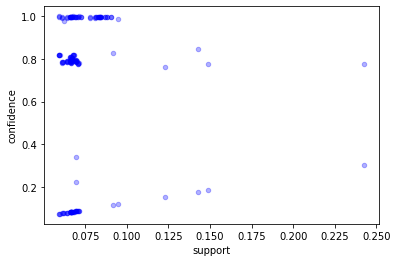

In [124]:
import  matplotlib.pyplot as plt
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.confidence[i],s=20,c='b',alpha=(rules.lift.iloc[i])/(rules.lift.iloc[0])*0.8/(rules.lift.iloc[0]-rules.lift.iloc[-1])+0.3)

<h2 id = "6"> 附录 其它年份的挖掘结果</h2>
  
该部分除了应有的挖掘结果分析，略去了大部分的处理过程说明，具体的处理步骤参照正文中2011年的挖掘过程。

<h3 id="2012"> 2012</h3>

In [135]:
def reformat_arr(df):
    df_arr = df.apply(deal,axis=1).tolist()
    te = TransactionEncoder()
    df_tf = te.fit_transform(df_arr)
    df = pd.DataFrame(df_tf,columns=te.columns_)
    return df
def gen_rules(frequent_items):
    rules =  association_rules(frequent_items, metric='lift')
    rules = rules.sort_values(by=['lift'], ascending=False).reset_index(drop=True)
    rules = rules.drop(['leverage','conviction'],axis = 1)
    rules['cosine'] = metrics(rules,cosine)
    rules['Jaccard'] = metrics(rules,Jaccard)
    rules['Allconf'] = metrics(rules,allconf)
    rules['Maxconf'] = metrics(rules,maxconf)
    rules['Kulczynski'] = metrics(rules,Kulczynski)
    return rules
def draw_rule(rules):
    plt.xlabel('support')
    plt.ylabel('confidence')
    for i in range(rules.shape[0]):
        plt.scatter(rules.support[i],rules.confidence[i],s=20,c='b',alpha=(rules.lift.iloc[i])/(rules.lift.iloc[0])*0.8/(rules.lift.iloc[0]-rules.lift.iloc[-1])+0.3)

In [130]:
# 数据形式转化
df = reformat_df(df,'records-for-2012.csv')
df = add_prefix(df,'records-for-2012.csv')
df = reformat_arr(df)
df.head(3)

,01X,02X,02Y,03X,03Y,04X,05X,05Y,06X,07X,...,cre9,d1,d2,d3,d4,d5,d6,d7,p1.0,p2.0
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True


In [131]:
# 频繁模式
frequent_items = apriori(df, min_support=0.05, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)	
frequent_items.head(30)

,support,itemsets
34,0.776311,(p2.0)
30,0.321852,(d4)
78,0.242322,"(d4, p2.0)"
33,0.223689,(p1.0)
29,0.177598,(d3)
27,0.156159,(d1)
28,0.142115,(d2)
76,0.133183,"(p2.0, d3)"
74,0.129810,"(d1, p2.0)"
31,0.124554,(d5)


In [133]:
# 关联规则与评价
rules = gen_rules(frequent_items)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,(cls2),"(cre2, p2.0)",0.073362,0.057392,0.057216,0.779911,13.589134,0.881770,0.778044,0.779911,0.996932,0.888422
1,"(cre2, p2.0)",(cls2),0.057392,0.073362,0.057216,0.996932,13.589134,0.881770,0.778044,0.779911,0.996932,0.888422
2,"(p2.0, cls2)",(cre2),0.057430,0.073352,0.057216,0.996284,13.582272,0.881547,0.777762,0.780025,0.996284,0.888154
3,(cre2),"(p2.0, cls2)",0.073352,0.057430,0.057216,0.780025,13.582272,0.881547,0.777762,0.780025,0.996284,0.888154
4,(cre2),(cls2),0.073352,0.073362,0.073085,0.996363,13.581377,0.996290,0.992608,0.996218,0.996363,0.996290
...,...,...,...,...,...,...,...,...,...,...,...,...
157,(d4),(p2.0),0.321852,0.776311,0.242322,0.752897,0.969840,0.484782,0.283139,0.312145,0.752897,0.532521
158,(d3),(p2.0),0.177598,0.776311,0.133183,0.749910,0.965992,0.358683,0.162274,0.171558,0.749910,0.460734
159,(p2.0),(d3),0.776311,0.177598,0.133183,0.171558,0.965992,0.358683,0.162274,0.171558,0.749910,0.460734
160,(p2.0),(d2),0.776311,0.142115,0.104871,0.135088,0.950558,0.315730,0.128904,0.135088,0.737929,0.436509


In [134]:
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,(cls2),"(cre2, p2.0)",0.073362,0.057392,0.057216,0.779911,13.589134,0.881770,0.778044,0.779911,0.996932,0.888422
1,"(cre2, p2.0)",(cls2),0.057392,0.073362,0.057216,0.996932,13.589134,0.881770,0.778044,0.779911,0.996932,0.888422
2,"(p2.0, cls2)",(cre2),0.057430,0.073352,0.057216,0.996284,13.582272,0.881547,0.777762,0.780025,0.996284,0.888154
3,(cre2),"(p2.0, cls2)",0.073352,0.057430,0.057216,0.780025,13.582272,0.881547,0.777762,0.780025,0.996284,0.888154
4,(cre2),(cls2),0.073352,0.073362,0.073085,0.996363,13.581377,0.996290,0.992608,0.996218,0.996363,0.996290
5,(cls2),(cre2),0.073362,0.073352,0.073085,0.996218,13.581377,0.996290,0.992608,0.996218,0.996363,0.996290
6,"(cls1, p2.0)",(cre1),0.061826,0.078757,0.061480,0.994390,12.626062,0.881047,0.777201,0.780623,0.994390,0.887507
7,(cre1),"(cls1, p2.0)",0.078757,0.061826,0.061480,0.780623,12.626062,0.881047,0.777201,0.780623,0.994390,0.887507
8,"(cre1, p2.0)",(cls1),0.061693,0.078949,0.061480,0.996540,12.622576,0.880926,0.776624,0.778724,0.996540,0.887632
9,(cls1),"(cre1, p2.0)",0.078949,0.061693,0.061480,0.778724,12.622576,0.880926,0.776624,0.778724,0.996540,0.887632


### 挖掘结果分析
首先所给的这些规则的lift都是远大于1的，说明项之间的正相关：
- 规则0，1，2，3说明在2月发生的优先度为2（最低优先度，程度轻微，如财产安全受到侵害）的案件通常都会在2月得到解决。这是和常识一致的，程度轻微的小案件一般处理的都快。
- 规则4，5说明在2月发生的案件一般在2月就会解决，可以挖掘出2月时警方的办案效率很高；
- 规则6，7，8，9说明在1月发生的优先度为2的案件通常都会在1月得到解决。

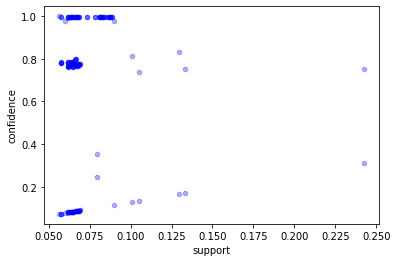

In [136]:
# 关联规则可视化
draw_rule(rules)

<h3 id="2013"> 2013</h3>

In [157]:
# 数据形式转化
df = reformat_df(df,'records-for-2013.csv')
df = add_prefix(df,'records-for-2013.csv')
df = reformat_arr(df)
df.head(3)

,01X,02X,02Y,03X,03Y,04X,05X,05Y,06X,07X,...,d1,d2,d3,d4,d5,d6,d7,p0.0,p1.0,p2.0
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False


In [158]:
# 频繁模式
frequent_items = apriori(df, min_support=0.05, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)	
frequent_items.head(30)

,support,itemsets
34,0.770316,(p2.0)
30,0.320941,(d4)
77,0.236224,"(d4, p2.0)"
33,0.229572,(p1.0)
29,0.167073,(d3)
27,0.142914,(d1)
31,0.134571,(d5)
28,0.133917,(d2)
75,0.123281,"(p2.0, d3)"
73,0.117219,"(d1, p2.0)"


In [159]:
# 关联规则与评价
rules = gen_rules(frequent_items)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,(cls2),(cre2),0.073698,0.073720,0.073278,0.994300,13.487561,0.994156,0.988380,0.994013,0.994300,0.994156
1,(cre2),(cls2),0.073720,0.073698,0.073278,0.994013,13.487561,0.994156,0.988380,0.994013,0.994300,0.994156
2,(cre2),"(p2.0, cls2)",0.073720,0.056953,0.056623,0.768088,13.486358,0.873866,0.764668,0.768088,0.994211,0.881149
3,"(p2.0, cls2)",(cre2),0.056953,0.073720,0.056623,0.994211,13.486358,0.873866,0.764668,0.768088,0.994211,0.881149
4,(cls2),"(cre2, p2.0)",0.073698,0.056995,0.056623,0.768309,13.480181,0.873666,0.764448,0.768309,0.993469,0.880889
...,...,...,...,...,...,...,...,...,...,...,...,...
157,(p2.0),(d3),0.770316,0.167073,0.123281,0.160039,0.957904,0.343644,0.151431,0.160039,0.737889,0.448964
158,(p2.0),(d4),0.770316,0.320941,0.236224,0.306659,0.955499,0.475092,0.276275,0.306659,0.736036,0.521348
159,(d4),(p2.0),0.320941,0.770316,0.236224,0.736036,0.955499,0.475092,0.276275,0.306659,0.736036,0.521348
160,(d2),(p2.0),0.133917,0.770316,0.097277,0.726403,0.942993,0.302873,0.120549,0.126282,0.726403,0.426343


In [160]:
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,(cls2),(cre2),0.073698,0.073720,0.073278,0.994300,13.487561,0.994156,0.988380,0.994013,0.994300,0.994156
1,(cre2),(cls2),0.073720,0.073698,0.073278,0.994013,13.487561,0.994156,0.988380,0.994013,0.994300,0.994156
2,(cre2),"(p2.0, cls2)",0.073720,0.056953,0.056623,0.768088,13.486358,0.873866,0.764668,0.768088,0.994211,0.881149
3,"(p2.0, cls2)",(cre2),0.056953,0.073720,0.056623,0.994211,13.486358,0.873866,0.764668,0.768088,0.994211,0.881149
4,(cls2),"(cre2, p2.0)",0.073698,0.056995,0.056623,0.768309,13.480181,0.873666,0.764448,0.768309,0.993469,0.880889
5,"(cre2, p2.0)",(cls2),0.056995,0.073698,0.056623,0.993469,13.480181,0.873666,0.764448,0.768309,0.993469,0.880889
6,(cls12),"(cre12, p2.0)",0.077697,0.060032,0.059734,0.768804,12.806595,0.874637,0.765869,0.768804,0.995039,0.881922
7,"(cre12, p2.0)",(cls12),0.060032,0.077697,0.059734,0.995039,12.806595,0.874637,0.765869,0.768804,0.995039,0.881922
8,(cls12),(cre12),0.077697,0.077687,0.077288,0.994730,12.804366,0.994798,0.989650,0.994730,0.994866,0.994798
9,(cre12),(cls12),0.077687,0.077697,0.077288,0.994866,12.804366,0.994798,0.989650,0.994730,0.994866,0.994798


### 挖掘结果分析
首先所给的这些规则的lift都是远大于1的，说明项之间的正相关：
- 规则2，3，4，5说明在2月发生的优先度为2（最低优先度，程度轻微，如财产安全受到侵害）的案件通常都会在2月得到解决。这是和常识一致的，程度轻微的小案件一般处理的都快。
- 规则0，1说明在2月发生的案件一般在2月就会解决，可以挖掘出2月时警方的办案效率很高；
- 规则6，7说明在12月发生的优先度为2的案件通常都会在12月得到解决。
- 规则8，9说明在12月发生的案件一般在12月就会解决，可以挖掘出12月时警方的办案效率很高；

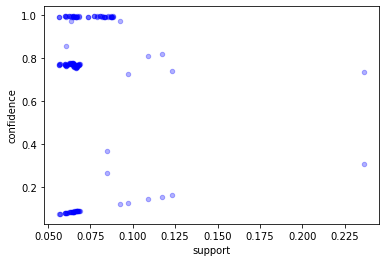

In [161]:
# 关联规则可视化
draw_rule(rules)

<h3 id="2014"> 2014</h3>

In [142]:
# 数据形式转化
df = reformat_df(df,'records-for-2014.csv')
df = add_prefix(df,'records-for-2014.csv')
df = reformat_arr(df)
df.head(3)

,01X,02X,02Y,03X,03Y,04X,05X,05Y,06X,07X,...,cre9,d1,d2,d3,d4,d5,d6,d7,p1,p2
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [143]:
# 频繁模式
frequent_items = apriori(df, min_support=0.05, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)	
frequent_items.head(30)

,support,itemsets
34,0.771853,(p2)
30,0.310604,(d4)
78,0.229875,"(d4, p2)"
33,0.228147,(p1)
29,0.164514,(d3)
27,0.149008,(d1)
28,0.136644,(d2)
31,0.133950,(d5)
74,0.123186,"(d1, p2)"
76,0.120354,"(p2, d3)"


In [144]:
# 关联规则与评价
rules = gen_rules(frequent_items)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,"(cls2, p2)",(cre2),0.058668,0.075859,0.058390,0.995272,13.120071,0.875262,0.766919,0.769723,0.995272,0.882498
1,(cre2),"(cls2, p2)",0.075859,0.058668,0.058390,0.769723,13.120071,0.875262,0.766919,0.769723,0.995272,0.882498
2,(cre2),(cls2),0.075859,0.075869,0.075475,0.994937,13.113812,0.994867,0.989787,0.994798,0.994937,0.994867
3,(cls2),(cre2),0.075869,0.075859,0.075475,0.994798,13.113812,0.994867,0.989787,0.994798,0.994937,0.994867
4,"(cre2, p2)",(cls2),0.058705,0.075869,0.058390,0.994639,13.109883,0.874922,0.766436,0.769615,0.994639,0.882127
...,...,...,...,...,...,...,...,...,...,...,...,...
159,(p2),(d4),0.771853,0.310604,0.229875,0.297822,0.958850,0.469485,0.269623,0.297822,0.740091,0.518957
160,(d2),(p2),0.136644,0.771853,0.100453,0.735147,0.952445,0.309316,0.124317,0.130146,0.735147,0.432646
161,(p2),(d2),0.771853,0.136644,0.100453,0.130146,0.952445,0.309316,0.124317,0.130146,0.735147,0.432646
162,(p2),(d3),0.771853,0.164514,0.120354,0.155929,0.947818,0.337748,0.147491,0.155929,0.731576,0.443752


In [145]:
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,"(cls2, p2)",(cre2),0.058668,0.075859,0.058390,0.995272,13.120071,0.875262,0.766919,0.769723,0.995272,0.882498
1,(cre2),"(cls2, p2)",0.075859,0.058668,0.058390,0.769723,13.120071,0.875262,0.766919,0.769723,0.995272,0.882498
2,(cre2),(cls2),0.075859,0.075869,0.075475,0.994937,13.113812,0.994867,0.989787,0.994798,0.994937,0.994867
3,(cls2),(cre2),0.075869,0.075859,0.075475,0.994798,13.113812,0.994867,0.989787,0.994798,0.994937,0.994867
4,"(cre2, p2)",(cls2),0.058705,0.075869,0.058390,0.994639,13.109883,0.874922,0.766436,0.769615,0.994639,0.882127
5,(cls2),"(cre2, p2)",0.075869,0.058705,0.058390,0.769615,13.109883,0.874922,0.766436,0.769615,0.994639,0.882127
6,(cls11),"(p2, cre11)",0.079294,0.061223,0.060924,0.768330,12.549798,0.874404,0.765447,0.768330,0.995121,0.881726
7,"(p2, cre11)",(cls11),0.061223,0.079294,0.060924,0.995121,12.549798,0.874404,0.765447,0.768330,0.995121,0.881726
8,(cre11),"(p2, cls11)",0.079150,0.061367,0.060924,0.769728,12.543128,0.874171,0.765447,0.769728,0.992786,0.881257
9,"(p2, cls11)",(cre11),0.061367,0.079150,0.060924,0.992786,12.543128,0.874171,0.765447,0.769728,0.992786,0.881257


### 挖掘结果分析
首先所给的这些规则的lift都是远大于1的，说明项之间的正相关：
- 规则0，1，4，5说明在2月发生的优先度为2（最低优先度，程度轻微，如财产安全受到侵害）的案件通常都会在2月得到解决。这是和常识一致的，程度轻微的小案件一般处理的都快。
- 规则2，3说明在2月发生的案件一般在2月就会解决，可以挖掘出2月时警方的办案效率很高；
- 规则6，7，8，9说明在11月发生的优先度为2的案件通常都会在11月得到解决。

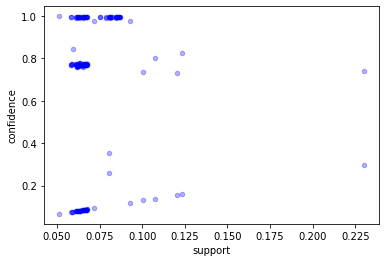

In [146]:
# 关联规则可视化
draw_rule(rules)

<h3 id="2015"> 2015</h3>

In [147]:
# 数据形式转化
df = reformat_df(df,'records-for-2015.csv')
df = add_prefix(df,'records-for-2015.csv')
df = reformat_arr(df)
df.head(3)

,01X,02X,02Y,03X,03Y,04X,05X,05Y,06X,07X,...,d1,d2,d3,d4,d5,d6,d7,p0,p1,p2
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [148]:
# 频繁模式
frequent_items = apriori(df, min_support=0.05, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)	
frequent_items.head(30)

,support,itemsets
33,0.779734,(p2)
29,0.303041,(d4)
76,0.227499,"(d4, p2)"
32,0.220261,(p1)
28,0.167026,(d3)
26,0.165702,(d1)
27,0.139988,(d2)
72,0.136924,"(d1, p2)"
74,0.124041,"(p2, d3)"
30,0.123906,(d5)


In [149]:
# 关联规则与评价
rules = gen_rules(frequent_items)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,(cre11),"(p2, cls11)",0.075823,0.060421,0.060193,0.793864,13.138802,0.889304,0.791479,0.793864,0.996219,0.895041
1,"(p2, cls11)",(cre11),0.060421,0.075823,0.060193,0.996219,13.138802,0.889304,0.791479,0.793864,0.996219,0.895041
2,(cls11),"(p2, cre11)",0.075926,0.060343,0.060193,0.792778,13.137766,0.889269,0.791209,0.792778,0.997505,0.895141
3,"(p2, cre11)",(cls11),0.060343,0.075926,0.060193,0.997505,13.137766,0.889269,0.791209,0.792778,0.997505,0.895141
4,(cre11),(cls11),0.075823,0.075926,0.075584,0.996850,13.129142,0.996168,0.992364,0.995486,0.996850,0.996168
...,...,...,...,...,...,...,...,...,...,...,...,...
157,(d4),(p2),0.303041,0.779734,0.227499,0.750720,0.962789,0.468010,0.265995,0.291765,0.750720,0.521242
158,(d2),(p2),0.139988,0.779734,0.104341,0.745354,0.955908,0.315816,0.127965,0.133815,0.745354,0.439585
159,(p2),(d2),0.779734,0.139988,0.104341,0.133815,0.955908,0.315816,0.127965,0.133815,0.745354,0.439585
160,(d3),(p2),0.167026,0.779734,0.124041,0.742648,0.952437,0.343717,0.150770,0.159082,0.742648,0.450865


In [150]:
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,(cre11),"(p2, cls11)",0.075823,0.060421,0.060193,0.793864,13.138802,0.889304,0.791479,0.793864,0.996219,0.895041
1,"(p2, cls11)",(cre11),0.060421,0.075823,0.060193,0.996219,13.138802,0.889304,0.791479,0.793864,0.996219,0.895041
2,(cls11),"(p2, cre11)",0.075926,0.060343,0.060193,0.792778,13.137766,0.889269,0.791209,0.792778,0.997505,0.895141
3,"(p2, cre11)",(cls11),0.060343,0.075926,0.060193,0.997505,13.137766,0.889269,0.791209,0.792778,0.997505,0.895141
4,(cre11),(cls11),0.075823,0.075926,0.075584,0.996850,13.129142,0.996168,0.992364,0.995486,0.996850,0.996168
5,(cls11),(cre11),0.075926,0.075823,0.075584,0.995486,13.129142,0.996168,0.992364,0.995486,0.996850,0.996168
6,(cre2),"(p2, cls2)",0.077635,0.060515,0.060292,0.776604,12.833284,0.879624,0.774376,0.776604,0.996310,0.886457
7,"(p2, cls2)",(cre2),0.060515,0.077635,0.060292,0.996310,12.833284,0.879624,0.774376,0.776604,0.996310,0.886457
8,(cls2),(cre2),0.077573,0.077635,0.077261,0.995984,12.829077,0.995584,0.991206,0.995184,0.995984,0.995584
9,(cre2),(cls2),0.077635,0.077573,0.077261,0.995184,12.829077,0.995584,0.991206,0.995184,0.995984,0.995584


### 挖掘结果分析
首先所给的这些规则的lift都是远大于1的，说明项之间的正相关：
- 规则4，5说明在11月发生的案件一般在11月就会解决，可以挖掘出11月时警方的办案效率很高；
- 规则0，1，2，3说明在11月发生的优先度为2（最低优先度，程度轻微，如财产安全受到侵害）的案件通常都会在11月得到解决。这是和常识一致的，程度轻微的小案件一般处理的都快。
- 规则6，7说明在2月发生的优先度为2的案件通常都会在2月得到解决。
- 规则8，9说明在2月发生的案件通常都会在12月得到解决，说明2月警方的办案效率很高。

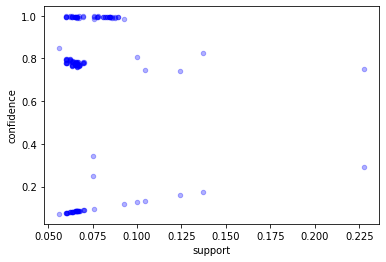

In [151]:
# 关联规则可视化
draw_rule(rules)

<h3 id="2016"> 2016</h3>

In [152]:
# 数据形式转化
df = reformat_df(df,'records-for-2016.csv')
df = add_prefix(df,'records-for-2016.csv')
df = reformat_arr(df)
df.head(3)

,01X,02X,02Y,03X,03Y,04X,05X,05Y,06X,07X,...,cre7,d1,d2,d3,d4,d5,d6,d7,p1.0,p2.0
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True


In [153]:
# 频繁模式
frequent_items = apriori(df, min_support=0.05, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)	
frequent_items.head(30)

,support,itemsets
23,0.778438,(p2.0)
19,0.301849,(d4)
51,0.225405,"(d4, p2.0)"
22,0.221562,(p1.0)
16,0.163038,(d1)
18,0.161215,(d3)
13,0.151145,(cre5)
6,0.150866,(cls5)
34,0.150243,"(cre5, cls5)"
14,0.147690,(cre6)


In [154]:
# 关联规则与评价
rules = gen_rules(frequent_items)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,"(cls1, p2.0)",(cre1),0.105507,0.134345,0.105507,1.000000,7.443549,0.886197,0.785345,0.785345,1.000000,0.892672
1,(cre1),"(cls1, p2.0)",0.134345,0.105507,0.105507,0.785345,7.443549,0.886197,0.785345,0.785345,1.000000,0.892672
2,(cls1),(cre1),0.133677,0.134345,0.133677,1.000000,7.443549,0.997512,0.995030,0.995030,1.000000,0.997515
3,(cre1),(cls1),0.134345,0.133677,0.133677,0.995030,7.443549,0.997512,0.995030,0.995030,1.000000,0.997515
4,(cls1),"(cre1, p2.0)",0.133677,0.106066,0.105507,0.789268,7.441273,0.886061,0.785978,0.789268,0.994726,0.891997
...,...,...,...,...,...,...,...,...,...,...,...,...
97,(d4),(p2.0),0.301849,0.778438,0.225405,0.746749,0.959291,0.465005,0.263668,0.289561,0.746749,0.518155
98,(d2),(p2.0),0.132251,0.778438,0.097115,0.734325,0.943331,0.302675,0.119369,0.124757,0.734325,0.429541
99,(p2.0),(d2),0.778438,0.132251,0.097115,0.124757,0.943331,0.302675,0.119369,0.124757,0.734325,0.429541
100,(d3),(p2.0),0.161215,0.778438,0.117201,0.726983,0.933899,0.330838,0.142501,0.150559,0.726983,0.438771


In [155]:
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,Jaccard,Allconf,Maxconf,Kulczynski
0,"(cls1, p2.0)",(cre1),0.105507,0.134345,0.105507,1.000000,7.443549,0.886197,0.785345,0.785345,1.000000,0.892672
1,(cre1),"(cls1, p2.0)",0.134345,0.105507,0.105507,0.785345,7.443549,0.886197,0.785345,0.785345,1.000000,0.892672
2,(cls1),(cre1),0.133677,0.134345,0.133677,1.000000,7.443549,0.997512,0.995030,0.995030,1.000000,0.997515
3,(cre1),(cls1),0.134345,0.133677,0.133677,0.995030,7.443549,0.997512,0.995030,0.995030,1.000000,0.997515
4,(cls1),"(cre1, p2.0)",0.133677,0.106066,0.105507,0.789268,7.441273,0.886061,0.785978,0.789268,0.994726,0.891997
5,"(cre1, p2.0)",(cls1),0.106066,0.133677,0.105507,0.994726,7.441273,0.886061,0.785978,0.789268,0.994726,0.891997
6,"(cre2, p2.0)",(cls2),0.105056,0.134597,0.104433,0.994074,7.385547,0.878234,0.772321,0.775893,0.994074,0.884983
7,(cls2),"(cre2, p2.0)",0.134597,0.105056,0.104433,0.775893,7.385547,0.878234,0.772321,0.775893,0.994074,0.884983
8,(cls2),(cre2),0.134597,0.134742,0.133938,0.995106,7.385297,0.994573,0.989204,0.994040,0.995106,0.994573
9,(cre2),(cls2),0.134742,0.134597,0.133938,0.994040,7.385297,0.994573,0.989204,0.994040,0.995106,0.994573


### 挖掘结果分析
首先所给的这些规则的lift都是远大于1的，说明项之间的正相关：
- 规则0，1，4，5说明在1月发生的优先度为2（最低优先度，程度轻微，如财产安全受到侵害）的案件通常都会在1月得到解决。这是和常识一致的，程度轻微的小案件一般处理的都快。
- 规则2，3说明在1月发生的案件一般在1月就会解决，可以挖掘出1月时警方的办案效率很高；
- 规则6，7说明在2月发生的优先度为2的案件通常都会在2月得到解决。
- 规则8，9说明在2月发生的案件一般在2月就会解决，可以挖掘出2月时警方的办案效率很高；

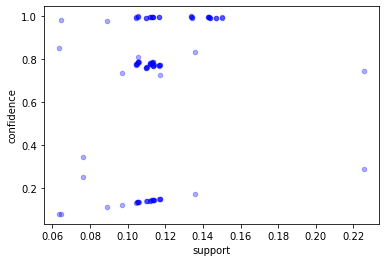

In [156]:
# 关联规则可视化
draw_rule(rules)